In [295]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow	import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV

### Intro:
This project will use the kaggle dataset [graduate_admissions](https://www.kaggle.com/mohansacharya/graduate-admissions?select=Admission_Predict_Ver1.1.csv) which contains the likelihood a given candidate would be admitted into a Masters Program based on a series of application factors. The goal of this project will be to build a deep learning regression that will be able to accurately predict the chance of a given students admission. Let's start by taking a look at the data.
 

In [287]:
admissions_df = pd.read_csv("admissions_data.csv")
admissions_df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [288]:
admissions_df["University Rating"].value_counts()

3    162
2    126
4    105
5     73
1     34
Name: University Rating, dtype: int64

In [289]:
admissions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         500 non-null    int64  
 1   GRE Score          500 non-null    int64  
 2   TOEFL Score        500 non-null    int64  
 3   University Rating  500 non-null    int64  
 4   SOP                500 non-null    float64
 5   LOR                500 non-null    float64
 6   CGPA               500 non-null    float64
 7   Research           500 non-null    int64  
 8   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 35.3 KB


In [290]:
admissions_df.describe()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,250.500000,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,144.481833,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,125.750000,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,250.500000,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,375.250000,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,500.000000,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


As shown above, there are 500 datapoints in our dataset, there are 8 columns, and there is no null data. Chance of Admit will be the target column that the regression we are building is going to predict. All of our columns are numerical, although it is a mix of nominal (research), ordinal (SOP), categorical (University Rating) and interval (GRE Score) data. We will use one hot encoding on the categorical data since we cannot assume that the difference between a 2 and a 3 is the same as the difference between a 4 and 5

### Exploratory Data Analysis

In [292]:
admissions_df.rename(columns={"Chance of Admit ": "Chance_of_admit", "University Rating": "University_Rating"}, inplace=True)

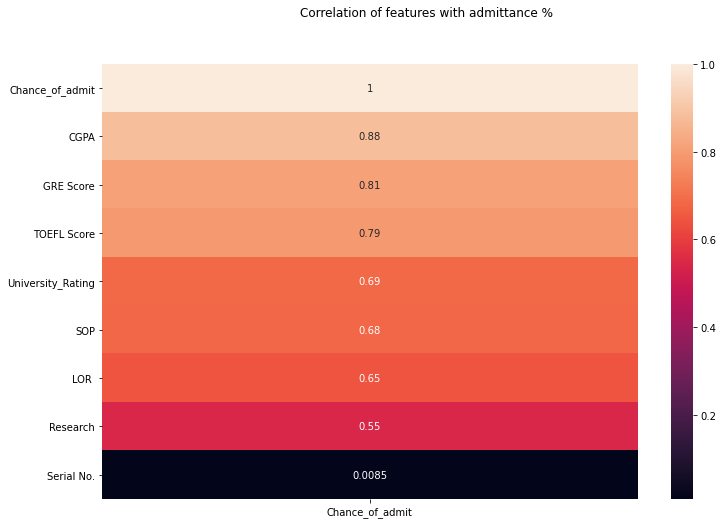

In [301]:
fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle('Correlation of features with admittance %')
corr = admissions_df.corr()[['Chance_of_admit']].sort_values(by='Chance_of_admit', ascending=False)
hm = sns.heatmap(corr, annot=True)

Text(0, 0.5, 'Admission %')

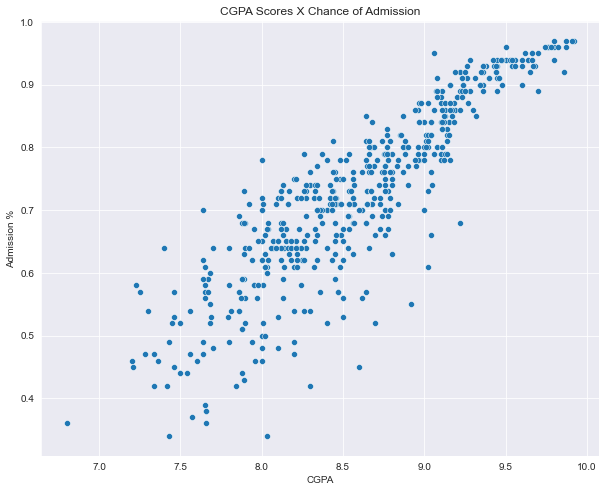

In [310]:
fig, ax = plt.subplots(figsize=(10,8))
sns.set_style('darkgrid')
sns.scatterplot(data=admissions_df, x='CGPA',y='Chance_of_admit')
ax.set_title('CGPA Scores X Chance of Admission')
ax.set_xlabel('CGPA')
ax.set_ylabel('Admission %')

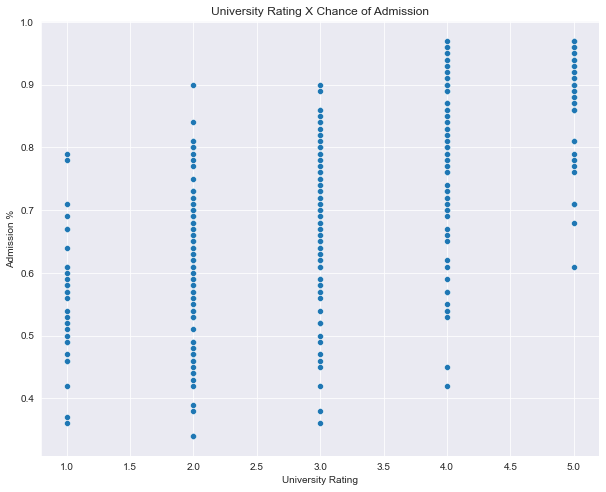

In [312]:
fig, ax = plt.subplots(figsize=(10,8))
sns.set_style('darkgrid')
sns.scatterplot(data=admissions_df, x='University_Rating',y='Chance_of_admit')
ax.set_title('University Rating X Chance of Admission')
ax.set_xlabel('University Rating')
ax.set_ylabel('Admission %');

### Preprocessing

In [36]:
admissions_df = pd.get_dummies(data = admissions_df, columns= ["University_Rating"])

In [37]:
##Splitting data into X (features) and y (target) variables
X = admissions_df.drop(labels=["Chance_of_admit"], axis=1)
y = admissions_df["Chance_of_admit"]

#Split further into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=42)

In [38]:
## Standardize data to give all features equal weight
ss = StandardScaler()
X_train_scale = ss.fit_transform(X_train)
X_test_scale = ss.transform(X_test)

In [39]:
## Take a look at how data looks scaled
pd.DataFrame(X_train_scale, columns=X_train.columns).head()

,Serial No.,GRE Score,TOEFL Score,SOP,LOR,CGPA,Research,University_Rating_1,University_Rating_2,University_Rating_3,University_Rating_4,University_Rating_5
0,0.006926,0.389986,0.602418,0.126796,0.564984,0.415018,0.895434,-0.269047,-0.581199,1.424887,-0.5,-0.420084
1,1.317425,-0.066405,0.602418,0.633979,1.651491,-0.067852,-1.116777,-0.269047,-0.581199,-0.701810,2.0,-0.420084
2,-1.631197,-1.253022,-0.876917,0.126796,-0.521524,-0.134454,-1.116777,-0.269047,-0.581199,1.424887,-0.5,-0.420084
3,0.526853,-0.248961,-0.055064,-0.887570,0.564984,-0.517420,-1.116777,-0.269047,1.720580,-0.701810,-0.5,-0.420084
4,0.598075,-0.796631,-0.219435,0.126796,-1.064777,-0.617324,0.895434,-0.269047,-0.581199,1.424887,-0.5,-0.420084


#### Baseline model (Linear Regression)

In [40]:
linreg = LinearRegression()
linreg.fit(X_train_scale, y_train)
linreg.score(X_train_scale, y_train)

0.8306842551270386

In [67]:
y_pred_lr = linreg.predict(X_test_scale)
r2 = r2_score(y_test, y_pred_lr)
mse = mean_squared_error(y_test, y_pred_lr)

In [68]:
print("Mean Squared Error: ", mse)
print("R-Squared Value: ", r2)

Mean Squared Error:  0.003493895019773117
R-Squared Value:  0.8291493877861557


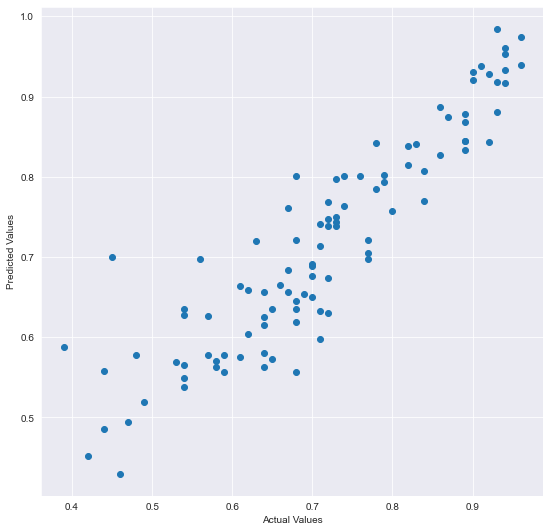

In [314]:
plt.figure(figsize=(9,9))
plt.scatter(y_test, y_pred_lr)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values');

Our baseline model of linear regression returned a fairly low mean squared error and a R-squared value of almost .83, pretty good! Lets see if we can beat those scores with a Neural Network.

#### First Deep Learning Model

In [42]:
X_train_scale.shape

(400, 12)

In [69]:
#Chosen to use a TF Keras Sequential model
model1 = Sequential()
#Input Layer
model_input = tf.keras.Input(shape=12)
model1.add(model_input)
#Hidden layer with 8 nuerons
first_layer = layers.Dense(8, activation = 'relu')
model1.add(first_layer)
#output layer
model1.add(layers.Dense(1))
#compile model - Adam optimizer, mean squared error for regression
opt = Adam(learning_rate=.01)
model1.compile(loss='mse', metrics=['mae'],optimizer=opt)

In [70]:
#Taking a look at the model summary
model1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________


In [71]:
#Fit the model to training data using 50 epochs and batch size of 5
model1.fit(X_train_scale, y_train, epochs=50, batch_size=5, verbose=1)

Epoch 1/50
80/80 [==============================] - 0s 767us/step - loss: 0.1658 - mae: 0.2939
Epoch 2/50
80/80 [==============================] - 0s 638us/step - loss: 0.0173 - mae: 0.0999
Epoch 3/50
80/80 [==============================] - 0s 617us/step - loss: 0.0102 - mae: 0.0766
Epoch 4/50
80/80 [==============================] - 0s 697us/step - loss: 0.0075 - mae: 0.0649
Epoch 5/50
80/80 [==============================] - 0s 684us/step - loss: 0.0068 - mae: 0.0650
Epoch 6/50
80/80 [==============================] - 0s 706us/step - loss: 0.0061 - mae: 0.0595
Epoch 7/50
80/80 [==============================] - 0s 817us/step - loss: 0.0055 - mae: 0.0559
Epoch 8/50
80/80 [==============================] - 0s 797us/step - loss: 0.0052 - mae: 0.0566
Epoch 9/50
80/80 [==============================] - 0s 818us/step - loss: 0.0047 - mae: 0.0518
Epoch 10/50
80/80 [==============================] - 0s 837us/step - loss: 0.0044 - mae: 0.0516
Epoch 11/50
80/80 [==============================

In [72]:
# Evaluate model using test data
y_pred = model1.predict(X_test_scale)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("Model 1 R-Squared: ", r2)
print("Model 1 Mean Squared Error: ", mse)

Model 1 R-Squared:  0.8042044544559663
Model 1 Mean Squared Error:  0.004004018906375489


Not bad scores, but not better than the oringinal linear regression...lets see if we can modify the model to do better by adding another activation layer, Dropout layers and an early stopping feature

In [191]:
def build_model():
    model = Sequential()
#Input layer
    inpt = layers.InputLayer(input_shape=(12,))
    model.add(inpt)
#Hidden layers
    first_layer = layers.Dense(16, activation='relu')
    model.add(first_layer)
    model.add(layers.Dropout(.1))
    second_layer = layers.Dense(8, activation='relu')
    model.add(second_layer)
    model.add(layers.Dropout(.2))
#Output layer
    model.add(layers.Dense(1))
#Compile 
    opt = Adam(learning_rate=.01)
    model.compile(loss='mse', metrics=['mae'],optimizer=opt)
    return model


In [192]:
model2 = build_model()
print(model2.summary())

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 16)                208       
_________________________________________________________________
dropout_36 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_63 (Dense)             (None, 8)                 136       
_________________________________________________________________
dropout_37 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 9         
Total params: 353
Trainable params: 353
Non-trainable params: 0
_________________________________________________________________
None


In [193]:
early_stop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=30)

In [194]:
model2.fit(X_train_scale, y_train, epochs=50, batch_size=5, verbose=1, validation_split=.2, callbacks=[early_stop])

Epoch 1/50
64/64 [==============================] - 0s 2ms/step - loss: 0.1783 - mae: 0.3218 - val_loss: 0.0300 - val_mae: 0.1385
Epoch 2/50
64/64 [==============================] - 0s 1ms/step - loss: 0.0331 - mae: 0.1474 - val_loss: 0.0111 - val_mae: 0.0807
Epoch 3/50
64/64 [==============================] - 0s 1ms/step - loss: 0.0184 - mae: 0.1028 - val_loss: 0.0078 - val_mae: 0.0648
Epoch 4/50
64/64 [==============================] - 0s 948us/step - loss: 0.0118 - mae: 0.0841 - val_loss: 0.0080 - val_mae: 0.0685
Epoch 5/50
64/64 [==============================] - 0s 1ms/step - loss: 0.0113 - mae: 0.0809 - val_loss: 0.0080 - val_mae: 0.0696
Epoch 6/50
64/64 [==============================] - 0s 1ms/step - loss: 0.0087 - mae: 0.0723 - val_loss: 0.0075 - val_mae: 0.0660
Epoch 7/50
64/64 [==============================] - 0s 1ms/step - loss: 0.0095 - mae: 0.0731 - val_loss: 0.0072 - val_mae: 0.0664
Epoch 8/50
64/64 [==============================] - 0s 966us/step - loss: 0.0087 - mae: 

In [195]:
# Evaluate model using test data
y_pred = model2.predict(X_test_scale)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("Model 2 R-Squared: ", r2)
print("Model 2 Mean Squared Error: ", mse)

Model 2 R-Squared:  0.7053887797107417
Model 2 Mean Squared Error:  0.006024799454915335


The extra steps made the predictions less accurate :(

Let's see if we can improve the r-squared with some hyperameter tuning

### Grid Search

In [234]:
batch_sizes = [5, 10, 25, 50]
epochs = [40, 100, 250]
param_grid = dict(batch_size=batch_sizes,epochs=epochs)

In [235]:
#use KerasRegressor so ScikitLearn will be able to work with it
gridmodel = KerasRegressor(build_fn=build_model, verbose=0)

In [236]:
grid = GridSearchCV(
    estimator=gridmodel, 
    param_grid=param_grid, 
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    n_jobs=-1
)

In [237]:
result = grid.fit(X_train_scale, y_train)
print(result.best_params_)

{'batch_size': 25, 'epochs': 250}


In [244]:
model2.fit(X_train_scale, y_train, epochs=250, batch_size=25, verbose=1, validation_split=.2, callbacks=[early_stop])

Epoch 1/250
13/13 [==============================] - 0s 6ms/step - loss: 0.0043 - mae: 0.0500 - val_loss: 0.0050 - val_mae: 0.0544
Epoch 2/250
13/13 [==============================] - 0s 3ms/step - loss: 0.0047 - mae: 0.0481 - val_loss: 0.0050 - val_mae: 0.0513
Epoch 3/250
13/13 [==============================] - 0s 3ms/step - loss: 0.0040 - mae: 0.0470 - val_loss: 0.0049 - val_mae: 0.0518
Epoch 4/250
13/13 [==============================] - 0s 4ms/step - loss: 0.0037 - mae: 0.0447 - val_loss: 0.0048 - val_mae: 0.0507
Epoch 5/250
13/13 [==============================] - 0s 4ms/step - loss: 0.0042 - mae: 0.0473 - val_loss: 0.0048 - val_mae: 0.0506
Epoch 6/250
13/13 [==============================] - 0s 4ms/step - loss: 0.0033 - mae: 0.0416 - val_loss: 0.0050 - val_mae: 0.0519
Epoch 7/250
13/13 [==============================] - 0s 4ms/step - loss: 0.0033 - mae: 0.0431 - val_loss: 0.0050 - val_mae: 0.0562
Epoch 8/250
13/13 [==============================] - 0s 6ms/step - loss: 0.0038 - m

In [245]:
# Evaluate model using test data
y_pred = model2.predict(X_test_scale)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("Model 2 R-Squared: ", r2)
print("Model 2 Mean Squared Error: ", mse)

Model 2 R-Squared:  0.746706840145594
Model 2 Mean Squared Error:  0.005179845119022605


Well there's improvement, but still not better than the first model or the linear regression model, maybe we overcomplicated it by adding a second layer, lets work with the first model again

### Final Model

In [246]:
def create_model():
    model = Sequential()
    inpt = layers.InputLayer(input_shape=(12,))
    model.add(inpt)
    
    layer = layers.Dense(16, activation='relu')
    model.add(layer)
    model.add(layers.Dropout(0.1))
    
    model.add(layers.Dense(1))
    
    opt = Adam(learning_rate=.005)
    model.compile(loss='mse', metrics=['mae'],optimizer=opt)
    return model

In [247]:
finalmodel=create_model()

In [248]:
print(finalmodel.summary())

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 16)                208       
_________________________________________________________________
dropout_44 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_75 (Dense)             (None, 1)                 17        
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
None


In [249]:
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=20)

In [250]:
fm = finalmodel.fit(X_train_scale, y_train, epochs=100, batch_size= 20, verbose=1, validation_split=.2,callbacks=[es])

Epoch 1/100
16/16 [==============================] - 0s 7ms/step - loss: 0.4476 - mae: 0.4917 - val_loss: 0.1595 - val_mae: 0.3305
Epoch 2/100
16/16 [==============================] - 0s 2ms/step - loss: 0.1740 - mae: 0.3051 - val_loss: 0.0644 - val_mae: 0.1957
Epoch 3/100
16/16 [==============================] - 0s 2ms/step - loss: 0.1039 - mae: 0.2437 - val_loss: 0.0476 - val_mae: 0.1732
Epoch 4/100
16/16 [==============================] - 0s 2ms/step - loss: 0.0714 - mae: 0.1876 - val_loss: 0.0394 - val_mae: 0.1504
Epoch 5/100
16/16 [==============================] - 0s 2ms/step - loss: 0.0621 - mae: 0.1802 - val_loss: 0.0302 - val_mae: 0.1318
Epoch 6/100
16/16 [==============================] - 0s 2ms/step - loss: 0.0588 - mae: 0.1693 - val_loss: 0.0256 - val_mae: 0.1185
Epoch 7/100
16/16 [==============================] - 0s 2ms/step - loss: 0.0465 - mae: 0.1517 - val_loss: 0.0210 - val_mae: 0.1082
Epoch 8/100
16/16 [==============================] - 0s 2ms/step - loss: 0.0391 - m

16/16 [==============================] - 0s 2ms/step - loss: 0.0040 - mae: 0.0478 - val_loss: 0.0036 - val_mae: 0.0454
Epoch 64/100
16/16 [==============================] - 0s 2ms/step - loss: 0.0037 - mae: 0.0460 - val_loss: 0.0034 - val_mae: 0.0423
Epoch 65/100
16/16 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0448 - val_loss: 0.0033 - val_mae: 0.0419
Epoch 66/100
16/16 [==============================] - 0s 2ms/step - loss: 0.0043 - mae: 0.0484 - val_loss: 0.0034 - val_mae: 0.0413
Epoch 67/100
16/16 [==============================] - 0s 2ms/step - loss: 0.0039 - mae: 0.0484 - val_loss: 0.0034 - val_mae: 0.0419
Epoch 68/100
16/16 [==============================] - 0s 2ms/step - loss: 0.0036 - mae: 0.0453 - val_loss: 0.0034 - val_mae: 0.0421
Epoch 69/100
16/16 [==============================] - 0s 2ms/step - loss: 0.0041 - mae: 0.0486 - val_loss: 0.0033 - val_mae: 0.0413
Epoch 70/100
16/16 [==============================] - 0s 2ms/step - loss: 0.0035 - mae: 0

In [252]:
y_pred = finalmodel.predict(X_test_scale)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("Final Model R-Squared: ", r2)
print("Final Model Mean Squared Error: ", mse)

Final Model R-Squared:  0.8089200032437709
Final Model Mean Squared Error:  0.003907585933664885


We were able to improve on the Neural Network score, but still couldn't beat the darn Linear regression!
This is likely due to the smaller nature of the dataset we are using (500 datapoints), Neural networks tend to perform their best with very large datasets. At least we gained some solid expierence using Deep Learning for a regression 

''

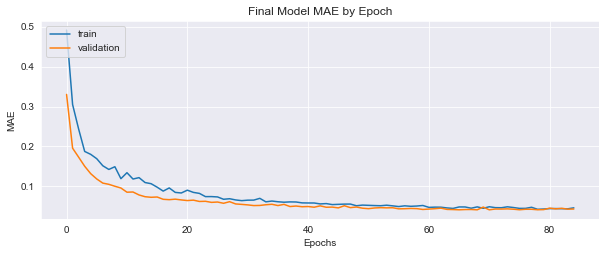

In [309]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(fm.history['mae'])
ax1.plot(fm.history['val_mae'])
ax1.set_title("Final Model MAE by Epoch")
ax1.set_ylabel('MAE')
ax1.set_xlabel('Epochs')
ax1.legend(['train', 'validation'], loc='upper left')
;

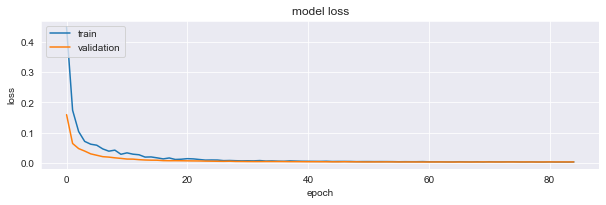

In [308]:
fig = plt.figure(figsize = (10, 6))
ax2 = fig.add_subplot(2, 1, 1)
ax2.plot(fm.history['loss'])
ax2.plot(fm.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'validation'], loc='upper left');

Looking at the MAE and loss graphs over the epochs, it seems that our model may be overfit, lets try another model with 40 epochs

In [278]:
fm2 = finalmodel.fit(X_train_scale, y_train, epochs=40, batch_size= 20, verbose=1, validation_split=.2,callbacks=[es])

Epoch 1/40
16/16 [==============================] - 0s 3ms/step - loss: 0.0039 - mae: 0.0458 - val_loss: 0.0036 - val_mae: 0.0448
Epoch 2/40
16/16 [==============================] - 0s 2ms/step - loss: 0.0035 - mae: 0.0453 - val_loss: 0.0035 - val_mae: 0.0432
Epoch 3/40
16/16 [==============================] - 0s 2ms/step - loss: 0.0035 - mae: 0.0456 - val_loss: 0.0034 - val_mae: 0.0427
Epoch 4/40
16/16 [==============================] - 0s 2ms/step - loss: 0.0034 - mae: 0.0429 - val_loss: 0.0035 - val_mae: 0.0439
Epoch 5/40
16/16 [==============================] - 0s 3ms/step - loss: 0.0038 - mae: 0.0461 - val_loss: 0.0036 - val_mae: 0.0450
Epoch 6/40
16/16 [==============================] - 0s 2ms/step - loss: 0.0034 - mae: 0.0440 - val_loss: 0.0036 - val_mae: 0.0428
Epoch 7/40
16/16 [==============================] - 0s 2ms/step - loss: 0.0032 - mae: 0.0418 - val_loss: 0.0035 - val_mae: 0.0436
Epoch 8/40
16/16 [==============================] - 0s 2ms/step - loss: 0.0035 - mae: 0.04

In [279]:
y_pred = finalmodel.predict(X_test_scale)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("Final Model R-Squared: ", r2)
print("Final Model Mean Squared Error: ", mse)

Final Model R-Squared:  0.8194557937791782
Final Model Mean Squared Error:  0.003692129017215806


WOW! Our best score yet, we still couldn't beat Linear regression, but we came real close!